In [74]:
import os
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score

import warnings
# filter warnings
warnings.filterwarnings('ignore')

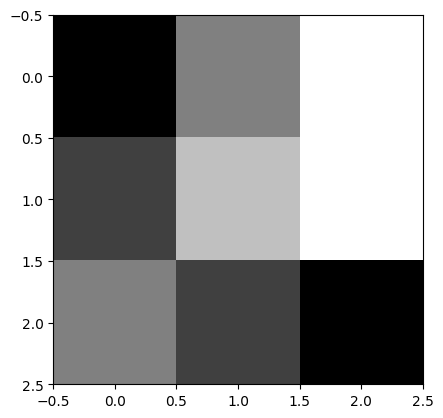

In [75]:
data = [[0, 128, 255], [64, 192, 255], [128, 64, 0]]
plt.imshow(data, cmap='gray')
plt.show()

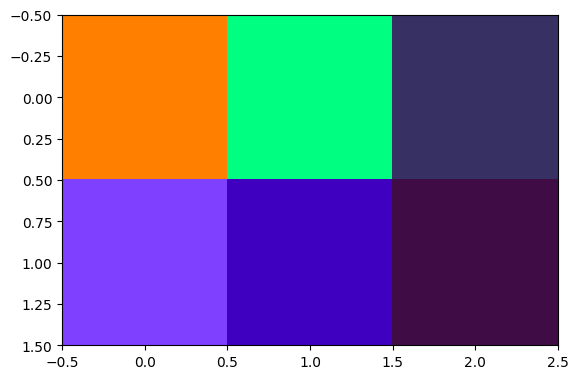

(2, 3, 3)

In [76]:
data = [[[255, 0, 54], [128, 64, 64]], [[128, 255, 49], [64, 0, 12]], [[0, 128, 98], [255, 192, 70]]]
data = np.moveaxis(data, 0, -1)
plt.imshow(data)
plt.show()
data.shape


1080 images in train_signs
Number of examples for class 0: 180


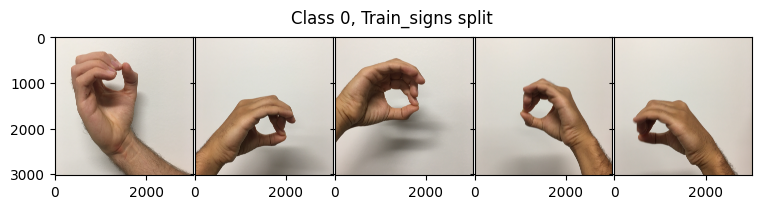

Number of examples for class 1: 180


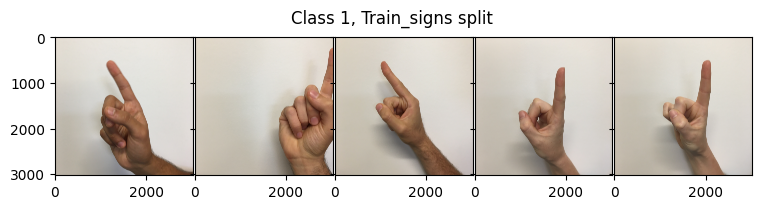

Number of examples for class 2: 180


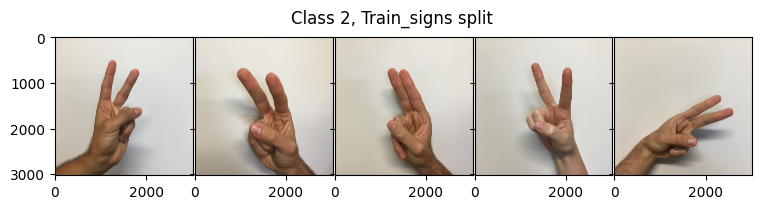

Number of examples for class 3: 180


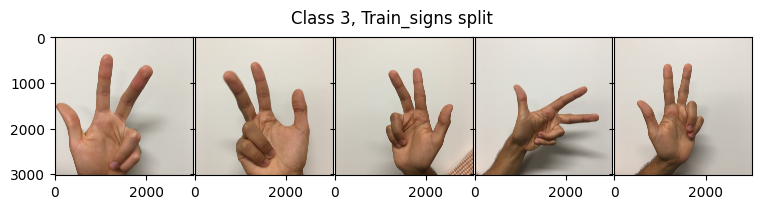

Number of examples for class 4: 180


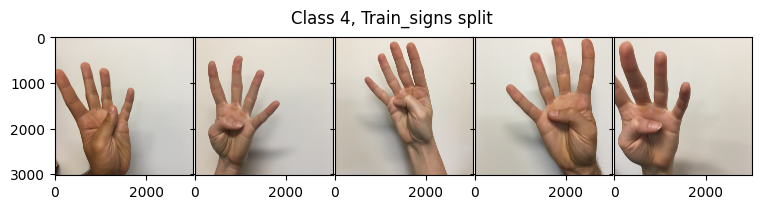

Number of examples for class 5: 180


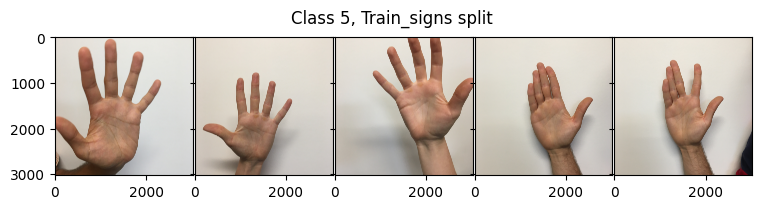

120 images in test_signs
Number of examples for class 0: 20
Number of examples for class 1: 20
Number of examples for class 2: 20
Number of examples for class 3: 20
Number of examples for class 4: 20
Number of examples for class 5: 20


In [77]:
data_path = os.path.join('SIGNS dataset')
splits = ['train_signs', 'test_signs']

for s in splits:
    folder = os.path.join(data_path, s)
    files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
    print(f'{len(files)} images in {s}')

    # for each image, create a list of the type [class, filename]
    files = [f.split('_',1) for f in files]

    # group the data by class
    files_by_sign = defaultdict(list)
    for k, v in files:
        files_by_sign[k].append(v)
    
      # take random 4 images of each class  
    for k, v in sorted(files_by_sign.items()):
        print(f'Number of examples for class {k}:', len(v))

        # display several examples of images from the training sample   
        if s == 'train_signs':        
            random.seed(42)
        
            imgs_path = random.sample(v, 5)
            imgs_path = [os.path.join(data_path, f'{s}/{k}_{p}') for p in imgs_path]

            # read the image using the opencv library
            imgs = [cv2.imread(p) for p in imgs_path]
            # matplotlib expects img in RGB format but OpenCV provides it in BGR       
            # transform the BGR image into RGB
            imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

                  # create a figure for display
            fig = plt.figure(figsize=(9, 2))
            grid = ImageGrid(
                fig, 111, 
                nrows_ncols=(1, 5)
            )
            # display the image
            for ax, img in zip(grid, imgs):
                ax.imshow(img)

            fig.suptitle(f'Class {k}, {s.capitalize()} split')
            plt.show()



In [78]:
orig_img = Image.fromarray(img)

def plot_examples(transformed_imgs:list, col_titles:list, cmap=None):
    
    n_cols = len(transformed_imgs) +1
    fig_size_x = 3 + len(transformed_imgs) * 1.5
    fig, axs = plt.subplots(1, n_cols, figsize=(fig_size_x,2))
    
    axs[0].imshow(orig_img)
    axs[0].set_title('original image')
    
    for i in range(len(transformed_imgs)):
        axs[i+1].imshow(transformed_imgs[i], cmap=cmap)
        axs[i+1].set_title(col_titles[i])
    
    plt.tight_layout()
    plt.show()


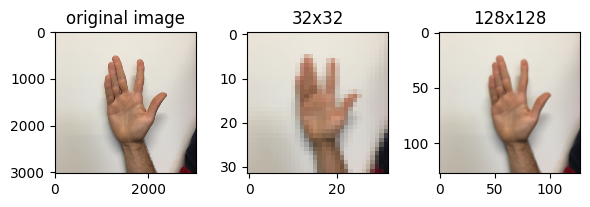

In [79]:
"""Resize
Аугментація з використанням resize уніфікує розміри вхідних зображень, 
забезпечуючи сумісність з мережею. Також вона збільшує обсяг навчального набору даних, 
роблячи модель стійкішою до масштабних варіацій."""

resized_imgs = [T.Resize(size=size)(orig_img) for size in [32,128]]
plot_examples(resized_imgs, ['32x32', '128x128'])

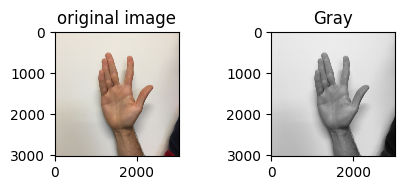

In [80]:
"""Gray Scale
Аугментація з використанням Gray Scale перетворює кольорові зображення на відтінки сірого. 
Це зменшує кількість каналів зображення, що може спростити роботу моделі, 
і зменшити вимоги до обчислювальних ресурсів"""

gray_img = T.Grayscale()(orig_img)
plot_examples([gray_img], ["Gray"], 'gray')

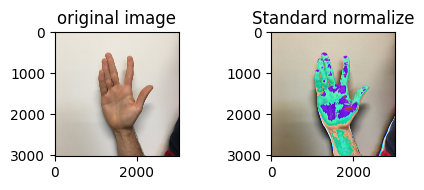

In [81]:
"""Normalize
Нормалізація може стати ефективним способом прискорення обчислень у моделі, 
заснованій на архітектурі нейронної мережі, і швидше навчатися. Є два кроки для нормалізації зображень:
- віднімаємо середнє значення каналу з кожного вхідного каналу,
- ділимо його на стандартне відхилення каналу."""

normalized_img = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(T.ToTensor()(orig_img)) 
normalized_img = [T.ToPILImage()(normalized_img)]
plot_examples(normalized_img, ["Standard normalize"])

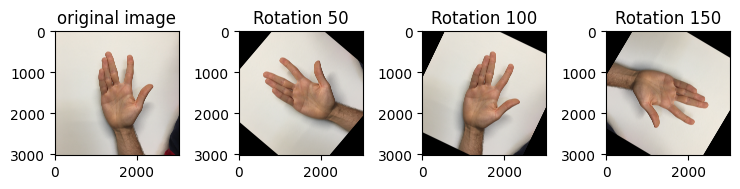

In [82]:
"""Random Rotation
Аугментація з використанням "Random Rotation" обертає зображення на випадковий кут. 
Це допомагає моделі стати стійкішою до різних кутів розміщення об'єктів на зображеннях."""

rotated_imgs = [T.RandomRotation(degrees=d)(orig_img) for d in range(50,151,50)]
plot_examples(rotated_imgs, ["Rotation 50","Rotation 100","Rotation 150"])

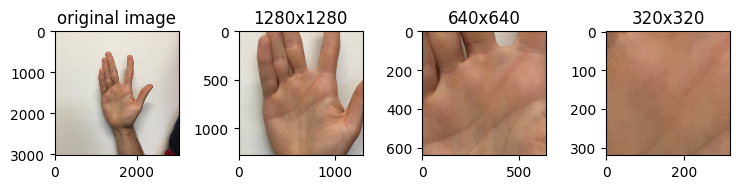

In [83]:
"""Center Crop
Аугментація з використанням Center Crop вирізає центральну частину зображення.
Це забезпечує фокусування на основних об'єктах та уніфікує розмір вхідних зображень."""

center_crops = [T.CenterCrop(size=size)(orig_img) for size in (1280,640, 320)]
plot_examples(center_crops,['1280x1280','640x640','320x320'])

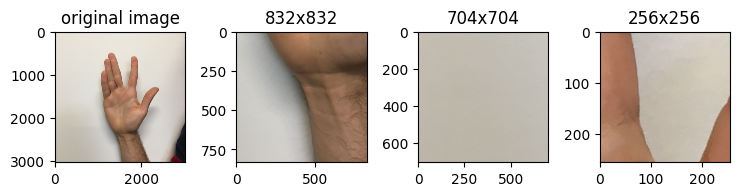

In [84]:
"""Random Crop
Аугментація з використанням "Random Crop" вирізає випадкову частину зображення. 
Це допомагає моделі стати стійкішою до ситуацій, коли об’єкт видно частково, 
і збільшує варіативність навчального набору даних."""

random_crops = [T.RandomCrop(size=size)(orig_img) for size in (832,704, 256)]
plot_examples(random_crops,['832x832','704x704','256x256'])

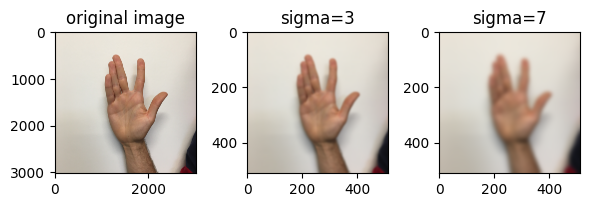

In [85]:
"""Gaussian Blur
Ми застосовуємо до зображення перетворення розмиття Гауса за допомогою ядра Гауса. 
Цей метод може бути корисним для того, щоб зробити зображення менш чітким і виразним. 
Потім отримане зображення подається в нейронну мережу, яка стає надійнішою у вивченні ознак вхідних даних."""

downsized_img = T.Resize(size=512)(orig_img)
blurred_imgs = [T.GaussianBlur(kernel_size=(51, 91), sigma=sigma)(downsized_img) for sigma in (3,7)]
plot_examples(blurred_imgs, ['sigma=3', 'sigma=7'])

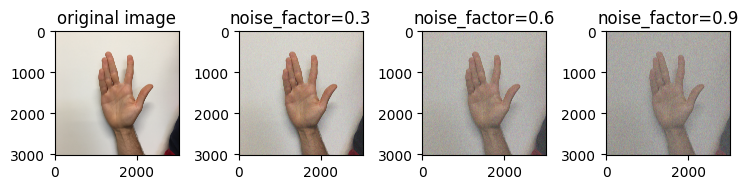

In [86]:
"""Gaussian Noise
Шум Гауса — це популярний спосіб додати шум до всього набору даних, змушуючи модель вивчати найважливішу інформацію, що міститься в даних. 
Він полягає у впровадженні матриці шуму Гауса, яка є матрицею випадкових значень, взятих із розподілу Гауса. 
Пізніше ми обрізаємо зразки між 0 і 1. Чим вищий коефіцієнт шуму, тим шумніше зображення."""

def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy
    
noise_imgs = [add_noise(T.ToTensor()(orig_img),noise_factor) for noise_factor in (0.3,0.6,0.9)]
noise_imgs = [T.ToPILImage()(noise_img) for noise_img in noise_imgs]
plot_examples(noise_imgs, ["noise_factor=0.3","noise_factor=0.6","noise_factor=0.9"])


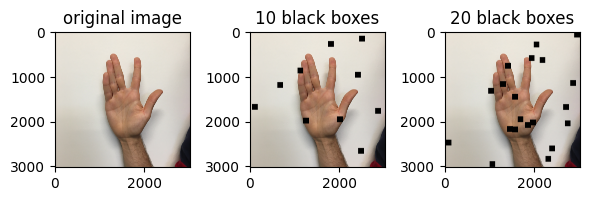

In [88]:
"""Random Blocks
Квадратні плями застосовуються як маски на зображенні випадковим чином. 
Чим більша кількість цих патчів, тим складнішою для нейронної мережі буде вирішення проблеми."""

def add_random_boxes(img,n_k,size=32):
    h,w = size,size
    img = np.array(img).copy()
    img_size = img.shape[1]
    boxes = []
    for k in range(n_k):
        y,x = np.random.randint(0,img_size-w,(2,))
        img[y:y+h,x:x+w] = 0
        boxes.append((x,y,h,w))
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    return img

blocks_imgs = [add_random_boxes(orig_img,n_k=i, size=128) for i in (10, 20)]
plot_examples(blocks_imgs, ["10 black boxes","20 black boxes"])


In [89]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.filename = os.listdir(data_dir)
        self.filename = [os.path.join(data_dir, f) for f in self.filename if f.endswith('.jpg')]

        self.labels = [int(filename.split('/')[-1][0]) for filename in self.filename]
        self.transform = transform
    
    def __len__(self):
        return len(self.filename)
    
    def __getitem__(self, idx):
        img = Image.open(self.filename[idx])
        img = self.transform(img)
        label = self.labels[idx]
        return img, label



In [90]:
train_transformer = T.Compose([
    T.Resize(64),              # resizing the image to 64x64 
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

eval_transformer = T.Compose([
    T.Resize(64),
    T.ToTensor()])

In [92]:
train_dataset = SIGNSDataset(f'{data_path}/train_signs/', train_transformer)
test_dataset = SIGNSDataset(f'{data_path}/test_signs/', eval_transformer)


In [93]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_channels = 32

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # classification layers
        self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)  # 6 classes

    def forward(self, s):
        s = self.conv1(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = self.conv2(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = self.conv3(s)
        s = F.relu(F.max_pool2d(s, 2))
        s = s.view(-1, self.num_channels*4*8*8)
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return F.log_softmax(s, dim=1)


In [94]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=32, 
                              shuffle=True,
                              num_workers=4)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32, 
                             shuffle=False,
                             num_workers=1)


In [ ]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else None

torch.manual_seed(42)
if cuda:
    cuda.manual_seed(42)
model = BaselineModel().to(device)


In [97]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []